In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
import optuna

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from PreprocessingFunction import build_preprocessor
from ValidationCross import cross_val_results


from collections import Counter

import joblib

RANDOM_STATE = 42

---
Load DataSet
---

In [33]:
# Load preprocessed data
df_cleaned = pd.read_csv("../data/preprocessed_data.csv")

In [34]:
# Split features and target variable
X = df_cleaned.drop('Exited', axis=1)
y = df_cleaned['Exited']

---
Preprocessing
---

In [35]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, stratify=y,random_state=42)

In [36]:
preprocessor = build_preprocessor(X_train)
ratio = Counter(y_train)[0] / Counter(y_train)[1]

---
Optuna
---

[I 2026-01-27 10:19:54,255] A new study created in memory with name: no-name-276239e5-3bf3-481b-84a4-c626b8380160
[I 2026-01-27 10:19:54,750] Trial 0 finished with value: 0.8511770512137385 and parameters: {'n_estimators': 194, 'max_depth': 3, 'learning_rate': 0.0622814286681032, 'subsample': 0.83264393527058}. Best is trial 0 with value: 0.8511770512137385.
[I 2026-01-27 10:20:04,128] Trial 1 finished with value: 0.7140538604659288 and parameters: {'n_estimators': 686, 'max_depth': 10, 'learning_rate': 0.03693432131118232, 'subsample': 0.813872253329438}. Best is trial 0 with value: 0.8511770512137385.
[I 2026-01-27 10:20:06,479] Trial 2 finished with value: 0.722843965374167 and parameters: {'n_estimators': 444, 'max_depth': 6, 'learning_rate': 0.1329553362106642, 'subsample': 0.8074256171271953}. Best is trial 0 with value: 0.8511770512137385.
[I 2026-01-27 10:20:07,433] Trial 3 finished with value: 0.8469990653470882 and parameters: {'n_estimators': 362, 'max_depth': 3, 'learning_r


--- ÉVALUATION OPTUNA ---
Accuracy: 0.895
Precision: 0.8043010752688172
Recall: 0.6254180602006689
F1-score: 0.7036688617121355
AUC: 0.9333059963965368

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.80      0.63      0.70       598

    accuracy                           0.90      3000
   macro avg       0.86      0.79      0.82      3000
weighted avg       0.89      0.90      0.89      3000



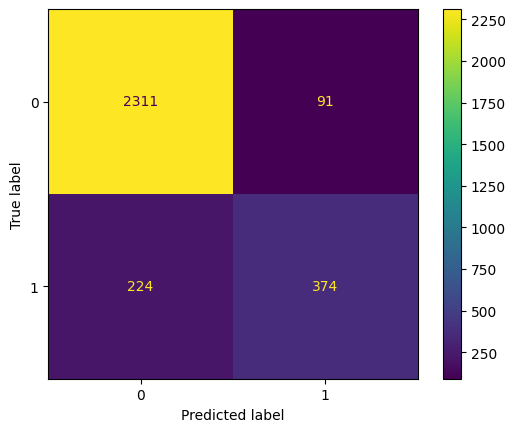

In [37]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "scale_pos_weight": ratio,
        "eval_metric": "logloss",
        "random_state": 42
    }
    model = XGBClassifier(**params)
    pipe = Pipeline([("preprocessor", preprocessor), ("classifier", model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    return cross_val_score(pipe, X_train, y_train, scoring="recall", cv=cv, n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_opt_xgb = XGBClassifier(**study.best_params, random_state=42)
optuna_pipe = Pipeline([("preprocessor", preprocessor), ("classifier", best_opt_xgb)])
optuna_pipe.fit(X_train, y_train)

print("\n--- ÉVALUATION OPTUNA ---")
evaluate_model(y_test, optuna_pipe.predict(X_test), optuna_pipe.predict_proba(X_test)[:, 1])


---
GridSearchCV
---


--- ÉVALUATION GRIDSEARCH ---
Accuracy: 0.8936666666666667
Precision: 0.7924528301886793
Recall: 0.6321070234113713
F1-score: 0.7032558139534884
AUC: 0.9326063286168995

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.79      0.63      0.70       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



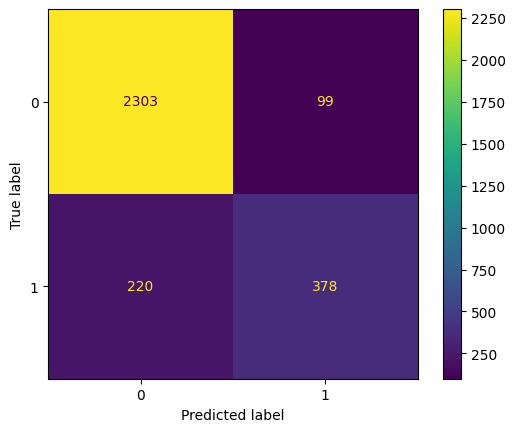

In [38]:
param_grid = {
    "classifier__n_estimators": [study.best_params["n_estimators"] - 50, study.best_params["n_estimators"] + 50],
    "classifier__max_depth": [study.best_params["max_depth"] - 1, study.best_params["max_depth"] + 1]
}

grid = GridSearchCV(optuna_pipe, param_grid, scoring="recall", cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n--- ÉVALUATION GRIDSEARCH ---")
evaluate_model(y_test, grid.predict(X_test), grid.predict_proba(X_test)[:, 1])

In [39]:
print("=== Cross Validation: Grid xgbBoost ===")
cross_val_results(grid, X_train, y_train)
print("=== Cross Validation: Optuna xgbBoost ===")
cross_val_results(optuna_pipe, X_train, y_train)

=== Cross Validation: Grid xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.9006 ± 0.0029
precision: 0.7914 ± 0.0084
recall: 0.6806 ± 0.0080
f1: 0.7318 ± 0.0080
roc_auc: 0.9355 ± 0.0039


=== Cross Validation: Optuna xgbBoost ===
----- Cross Validation Scores -----
accuracy: 0.9012 ± 0.0024
precision: 0.7986 ± 0.0051
recall: 0.6747 ± 0.0103
f1: 0.7314 ± 0.0076
roc_auc: 0.9360 ± 0.0039




---
Class Churn Imbalance 
---


>>> ANALYSE : Sans Équilibre
Recall Score: 0.6321
Accuracy: 0.8936666666666667
Precision: 0.7924528301886793
Recall: 0.6321070234113713
F1-score: 0.7032558139534884
AUC: 0.9326063286168995

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      2402
           1       0.79      0.63      0.70       598

    accuracy                           0.89      3000
   macro avg       0.85      0.80      0.82      3000
weighted avg       0.89      0.89      0.89      3000



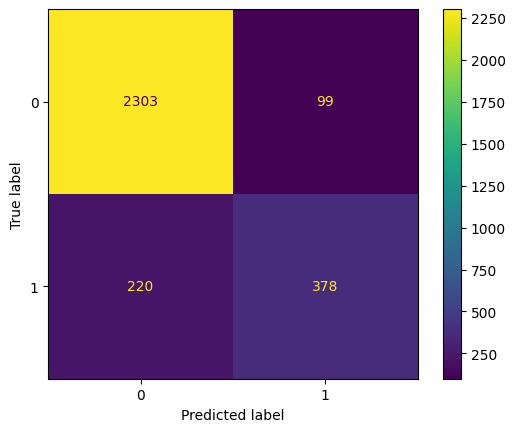


>>> ANALYSE : Weight Only
Recall Score: 0.8411
Accuracy: 0.865
Precision: 0.6186961869618696
Recall: 0.8411371237458194
F1-score: 0.7129695251594613
AUC: 0.9328144884836772

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2402
           1       0.62      0.84      0.71       598

    accuracy                           0.86      3000
   macro avg       0.79      0.86      0.81      3000
weighted avg       0.89      0.86      0.87      3000



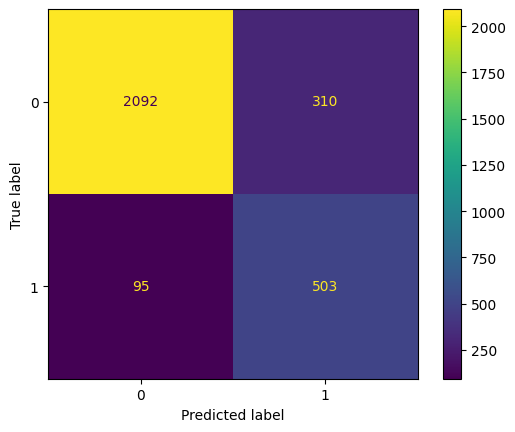


>>> ANALYSE : SMOTE Only
Recall Score: 0.7726
Accuracy: 0.887
Precision: 0.6947368421052632
Recall: 0.7725752508361204
F1-score: 0.7315914489311164
AUC: 0.931027376851509

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2402
           1       0.69      0.77      0.73       598

    accuracy                           0.89      3000
   macro avg       0.82      0.84      0.83      3000
weighted avg       0.89      0.89      0.89      3000



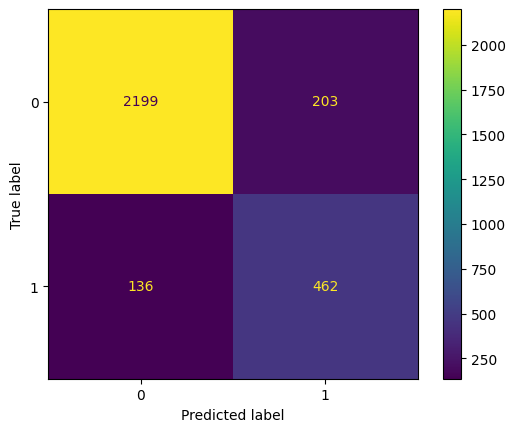


>>> ANALYSE : SMOTE + Weight
Recall Score: 0.9013
Accuracy: 0.8153333333333334
Precision: 0.5212765957446809
Recall: 0.9013377926421404
F1-score: 0.6605392156862745
AUC: 0.930473560215985

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      2402
           1       0.52      0.90      0.66       598

    accuracy                           0.82      3000
   macro avg       0.75      0.85      0.77      3000
weighted avg       0.88      0.82      0.83      3000



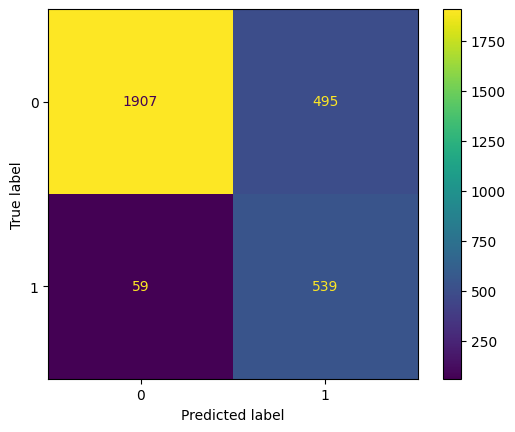

In [40]:
recall_opt = recall_score(y_test, optuna_pipe.predict(X_test))
recall_gs = recall_score(y_test, grid.predict(X_test))

best_params_moteur = grid.best_estimator_.named_steps['classifier'].get_params() if recall_gs >= recall_opt else best_opt_xgb.get_params()
best_params_moteur = {k: v for k, v in best_params_moteur.items() if k not in ['scale_pos_weight']}

strategies = {
    "Sans Équilibre": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "Weight Only": Pipeline([("preprocessor", preprocessor), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))]),
    "SMOTE Only": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=1))]),
    "SMOTE + Weight": ImbPipeline([("preprocessor", preprocessor), ("smote", SMOTE(random_state=42)), ("classifier", XGBClassifier(**best_params_moteur, scale_pos_weight=ratio))])
}

# Évaluation finale basée sur le Recall
final_recall = {}
for name, pipe in strategies.items():
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    
    # Stockage du recall
    final_recall[name] = recall_score(y_test, y_pred)
    
    print(f"\n>>> ANALYSE : {name}")
    print(f"Recall Score: {final_recall[name]:.4f}")
    evaluate_model(y_test, y_pred, y_prob)

---
Selection the best model
---

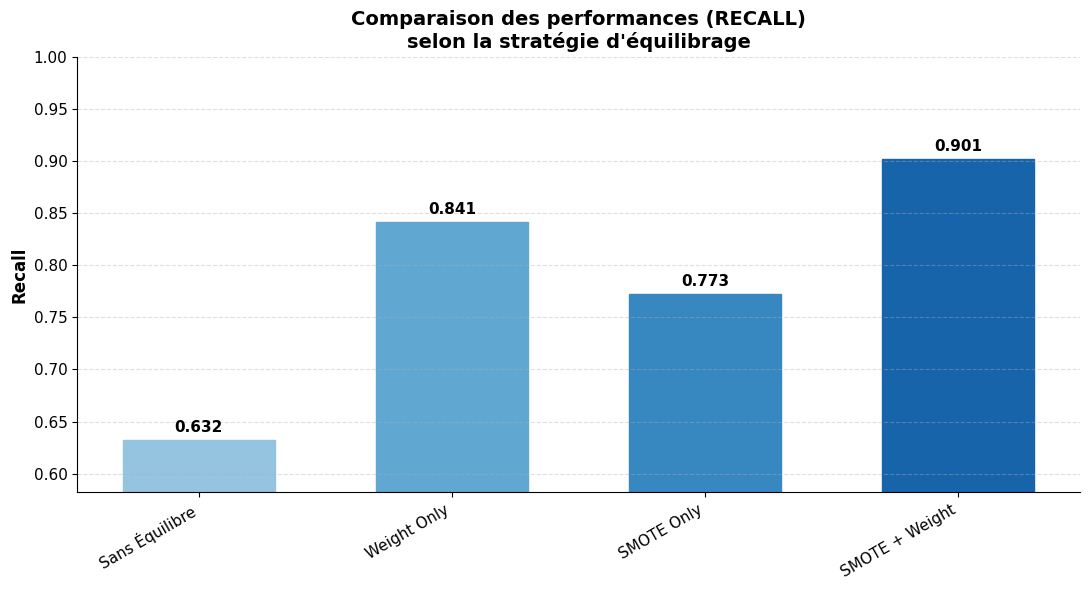

In [41]:
# --- DATA ---
labels = list(final_recall.keys())
values = list(final_recall.values())

# --- FIGURE ---
plt.figure(figsize=(11, 6))

bars = plt.bar(
    labels,
    values,
    width=0.6,
    edgecolor='black',
    linewidth=1
)

# --- COULEURS ---
colors = plt.cm.Blues(np.linspace(0.4, 0.8, len(bars)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

# --- ANNOTATIONS
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.005,
        f"{height:.3f}",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# --- AXES & TITRES ---
plt.ylim(min(values) - 0.05, 1.0)
plt.ylabel("Recall", fontsize=12, fontweight='bold')
plt.title(
    "Comparaison des performances (RECALL)\nselon la stratégie d'équilibrage",
    fontsize=14,
    fontweight='bold'
)
# --- STYLE PRO ---
plt.xticks(rotation=30, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Suppression des bordures inutiles
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

In [42]:
# Initialiser le dictionnaire AVANT la boucle
trained_models = {}

# Boucle d'entraînement
for name, model in strategies.items():
    # Entraîner le modèle
    if name == 'XGBoost':
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)
    else:
        model.fit(X_train, y_train)
    
    #  AJOUTEZ CETTE LIGNE :
    trained_models[name] = model  # Stocke le modèle ENTRAÎNÉ

In [54]:
# sauvegarde l'OBJET MODÈLE
best_key = max(final_recall, key=final_recall.get)
best_model = trained_models[best_key]  # Récupérer le modèle entraîné

# Vérification de sécurité
if best_model is None:
    raise ValueError(f"Le modèle {best_key} n'a pas été correctement entraîné !")

# Sauvegarde CORRECTE
import joblib
joblib.dump(best_model, '../models/best_model.pkl')
print(f"✅ Modèle '{best_key}' sauvegardé dans models/best_model.pkl")

✅ Modèle 'SMOTE + Weight' sauvegardé dans models/best_model.pkl


In [57]:
import joblib

# Charger le modèle CORRECTEMENT depuis notebooks/
model_ = joblib.load("../models/best_model.pkl")

# Vérifier les features
print("Features attendues par le modèle :")
print(model_.feature_names_in_)

Features attendues par le modèle :
['CreditScore' 'Geography' 'Gender' 'Age' 'Tenure' 'Balance'
 'NumOfProducts' 'HasCrCard' 'IsActiveMember' 'EstimatedSalary'
 'Ratio_Balance_Salary' 'Ratio_Balance_Age' 'Ratio_Salary_Age'
 'Engagement_Score' 'Ratio_Products_Age' 'Relative_Salary'
 'Ratio_CreditScore_Age' 'Zero_Balance_HasCrCard' 'Low_Balance_Active'
 'Active_HasCrCard' 'Log_Salary']


In [52]:
print("=== Cross Validation: Meilleur Modèle ===")
cross_val_results(strategies[best_key], X_train, y_train)

=== Cross Validation: Meilleur Modèle ===
----- Cross Validation Scores -----
accuracy: 0.8176 ± 0.0051
precision: 0.5247 ± 0.0072
recall: 0.9039 ± 0.0128
f1: 0.6639 ± 0.0088
roc_auc: 0.9341 ± 0.0032


